# **IMPORT LIBRARIES**

In [76]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import joblib  
import matplotlib.pyplot as plt

# **LOAD DATASET**

In [77]:
# Load dataset
file_path = '/kaggle/input/mental-illness-dataset/Mentalillness.csv'  # Ganti dengan path yang benar
data = pd.read_csv(file_path)

# **DATA EXPLORATION AND CLEANING**

## **Check For Duplicate Column**

In [78]:
# Display column names to check for duplicates or similar names
column_names = data.columns
print("Column Names in the Dataset:")
print(column_names)

# Optionally, check for columns that have similar names (like 'Sleep disturbance' and 'Sleep disturbance.1')
duplicates = [col for col in column_names if 'Sleep disturbance' in col or 'Intrusive memories or flashback' in col]
print("\nColumns with similar names:")
print(duplicates)

Column Names in the Dataset:
Index(['ID', 'Inflated self-esteem', 'Distractibility',
       'Increase in goal-directed activity',
       'Excessive involvement in activities with high potential for painful consequences',
       'Racing thoughts', 'Decreased need for sleep',
       'More talkative than usual', 'Disorganized thinking or speech',
       'Intrusive memories or flashbacks', 'Diminished emotional expression',
       'Delusions', 'Hallucinations', 'Catatonic behavior', '1 month duration',
       'Depressed mood', 'Persistent sadness or low mood',
       'Loss of interest or pleasure in activities',
       'Fatigue or loss of energy',
       'Difficulty concentrating or making decisions',
       'Lack of sleep or oversleeping', 'Psychomotor agitation',
       'Thoughts of suicide', 'Weight loss or gain', 'Excessive worry or fear',
       'Fatigue', 'Sleep disturbance', 'Difficulty concentrating',
       'Restlessness', 'Irritability', '6 month duration',
       'Experiencing t

## **Drop Duplicate Column** 

In [79]:
# Hapus kolom yang tidak relevan
data = data.drop(columns=['Sleep disturbance.1', 'Intrusive memories or flashback'])  

## **Separate Features and Targets** 

In [80]:
# Memisahkan fitur dan target
features = data.drop(columns=['ID', 'Bipolar disorder', 'Schizophrenia', 'Depression', 'Anxiety disorder', 'PTSD'])
targets = data[['Bipolar disorder', 'Schizophrenia', 'Depression', 'Anxiety disorder', 'PTSD']]

# **Number of People Affected by Mental Illness**
This bar chart shows the number of people affected by different mental health conditions based on the dataset.


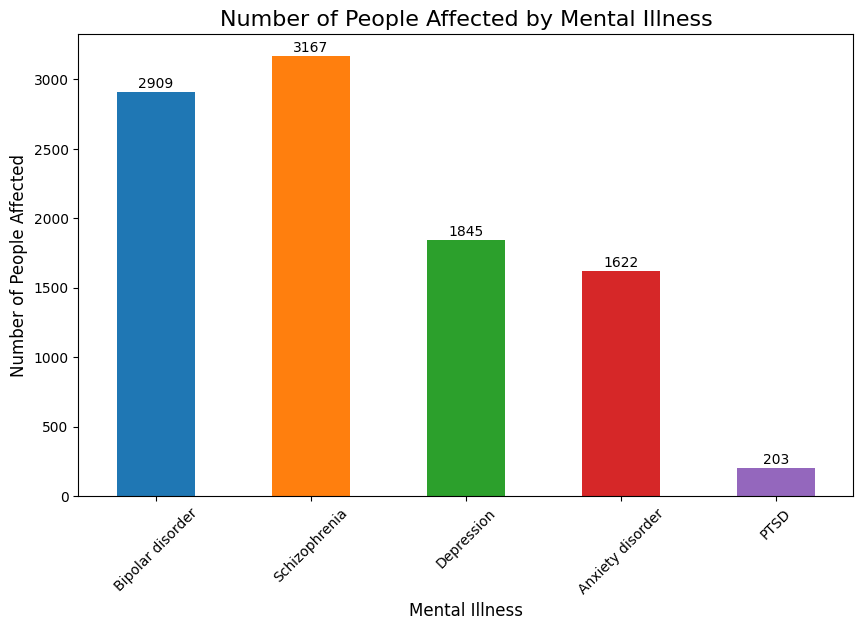

In [81]:
# Count the number of people affected by each mental illness
illness_counts = targets.sum()

# Create a bar chart to visualize the number of people affected by each illness
plt.figure(figsize=(10, 6))
bars = illness_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

# Add title and labels
plt.title('Number of People Affected by Mental Illness', fontsize=16)
plt.xlabel('Mental Illness', fontsize=12)
plt.ylabel('Number of People Affected', fontsize=12)

# Display the count values on top of the bars
for i, v in enumerate(illness_counts):
    bars.text(i, v + 10, str(v), ha='center', va='bottom', fontsize=10)

# Display the chart
plt.xticks(rotation=45)
plt.show()

# **Number of "Yes" Responses for Each Feature**
This bar chart shows how many individuals responded "Yes" to each feature in the dataset. It highlights the prevalence of various symptoms or behaviors.


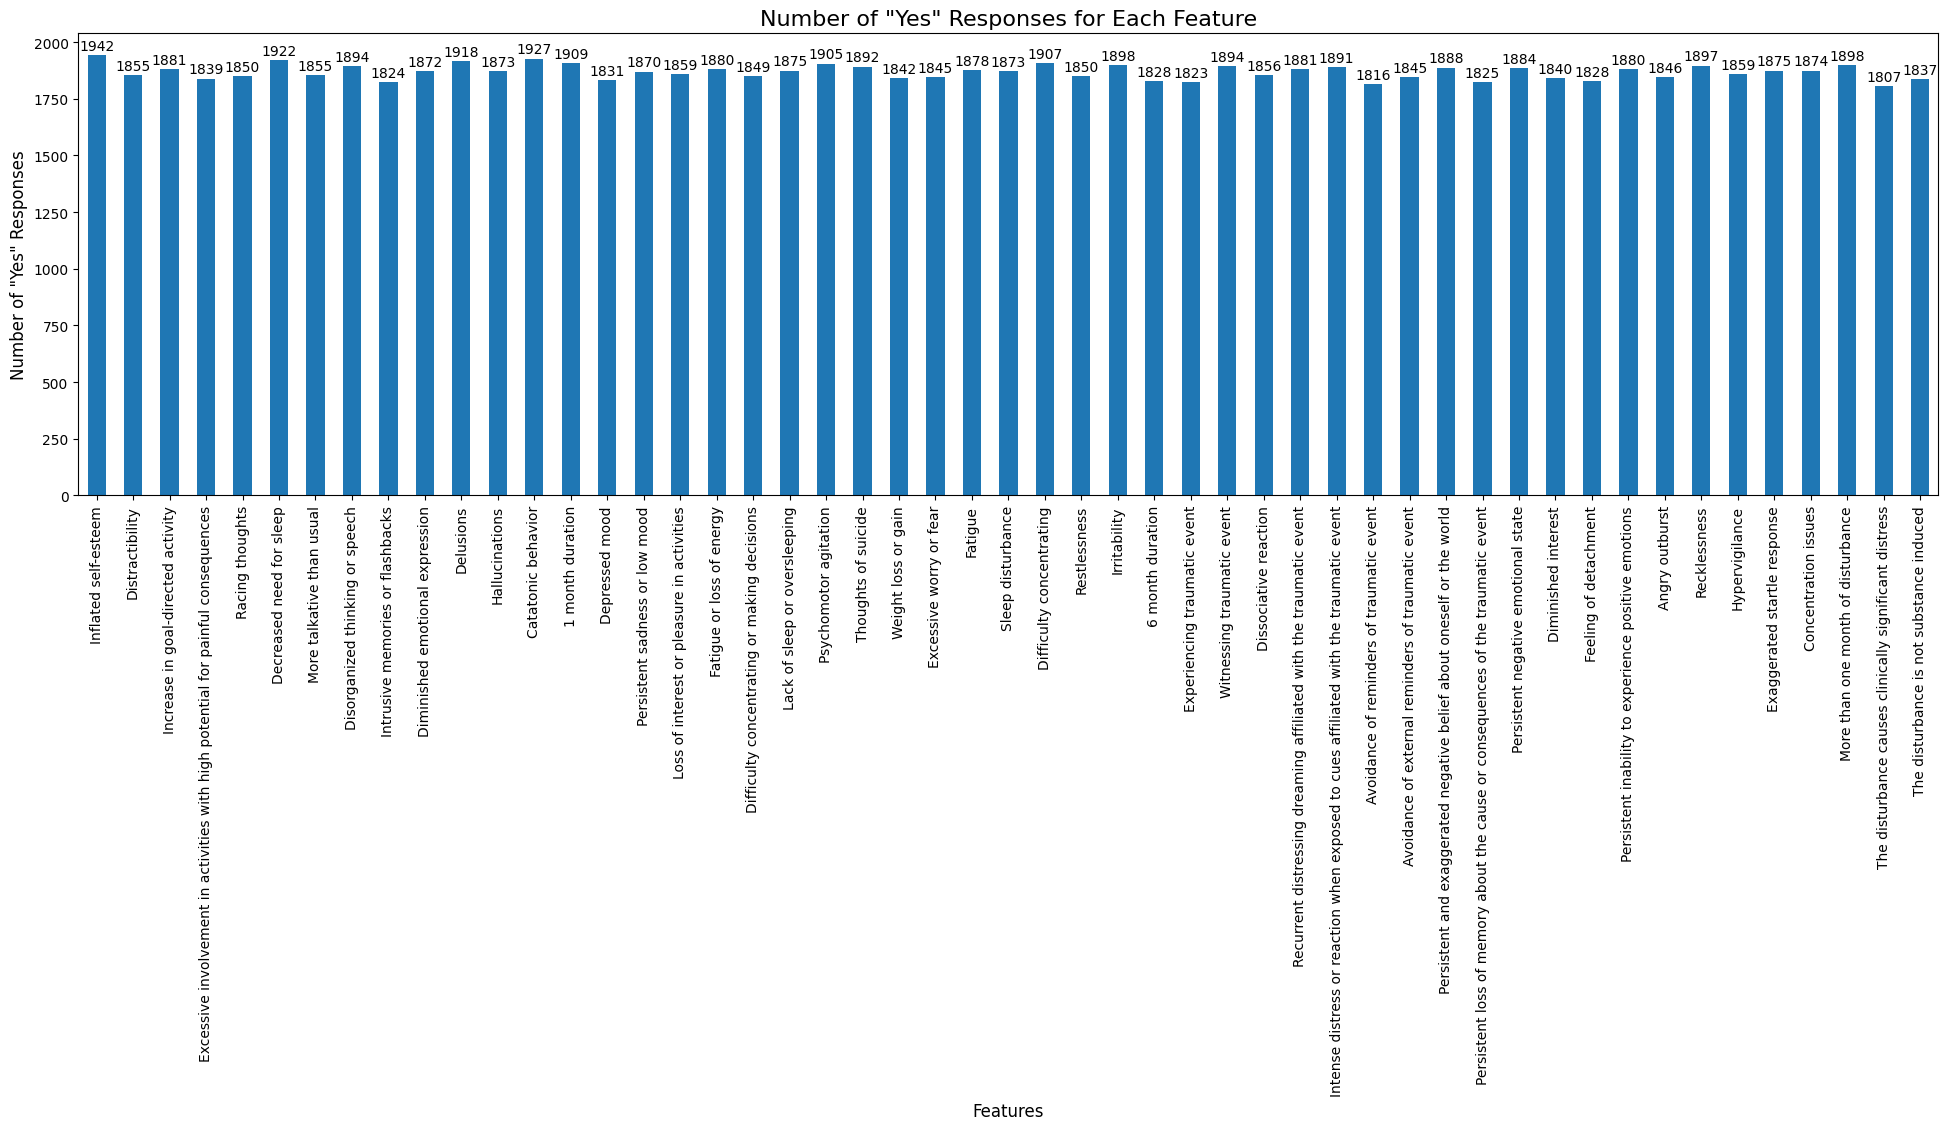

In [82]:
# Count the number of "Yes" responses (1) for each feature
feature_counts = features.sum()

# Create a bar chart to visualize the number of "Yes" responses for each feature
plt.figure(figsize=(24, 6))
bars = feature_counts.plot(kind='bar', color='#1f77b4')

# Add title and labels
plt.title('Number of "Yes" Responses for Each Feature', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Number of "Yes" Responses', fontsize=12)

# Display the count values on top of the bars
for i, v in enumerate(feature_counts):
    bars.text(i, v + 10, str(v), ha='center', va='bottom', fontsize=10)

# Display the chart
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

# **DATA PREPARATION**

## **Data Split**

In [83]:
# Membagi data menjadi training, validasi, dan test set
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)


## **Data Weighting**

In [84]:
# Menangani ketidakseimbangan kelas dengan menghitung scale_pos_weight
num_pos = sum(y_train.sum(axis=0))  # Total kelas positif
num_neg = len(y_train) * y_train.shape[1] - num_pos  # Total kelas negatif
scale_pos_weight = num_neg / num_pos
print(f"Scale Pos Weight: {scale_pos_weight}")

Scale Pos Weight: 0.9288100745309689


# **MODEL**

In [85]:
# Model XGBoost untuk multi-label classification
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', scale_pos_weight=scale_pos_weight)

# Melatih model
model.fit(X_train, y_train)

# Memprediksi hasil pada data test
y_pred = model.predict(X_test)


## **Train Model**

In [86]:
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', scale_pos_weight=scale_pos_weight)

# Melatih model
model.fit(X_train, y_train)

# Memprediksi hasil pada data test
y_pred = model.predict(X_test)


# **EVALUATION**

In [87]:
from sklearn.metrics import accuracy_score, f1_score

# Evaluasi akurasi dan F1 score untuk setiap label (penyakit mental)
for idx, label in enumerate(targets.columns):
    accuracy = accuracy_score(y_test[label], y_pred[:, idx])
    f1 = f1_score(y_test[label], y_pred[:, idx])
    print(f"Akurasi untuk {label}: {accuracy * 100:.2f}%")
    print(f"F1 Score untuk {label}: {f1:.2f}")

# Fungsi untuk memeriksa status Normal atau Penyakit Mental
def check_if_normal(predictions):
    # Jika semua kolom target prediksi adalah 0 (tidak ada penyakit terdeteksi), maka "normal"
    if np.all(predictions == 0):
        return "Normal"
    else:
        # Menampilkan label penyakit mental yang terdeteksi
        detected_labels = targets.columns[predictions == 1].tolist()
        return f"Penyakit Mental Terdeteksi: {', '.join(detected_labels)}"

# Menerapkan fungsi ke hasil prediksi untuk setiap individu
predictions_labels = [check_if_normal(pred) for pred in y_pred]

# Menampilkan hasil prediksi dengan status Normal atau Penyakit Mental
print("Prediksi dengan status Normal atau Penyakit Mental:")
print(predictions_labels[-5:])


Akurasi untuk Bipolar disorder: 100.00%
F1 Score untuk Bipolar disorder: 1.00
Akurasi untuk Schizophrenia: 100.00%
F1 Score untuk Schizophrenia: 1.00
Akurasi untuk Depression: 99.73%
F1 Score untuk Depression: 1.00
Akurasi untuk Anxiety disorder: 100.00%
F1 Score untuk Anxiety disorder: 1.00
Akurasi untuk PTSD: 98.40%
F1 Score untuk PTSD: 0.84
Prediksi dengan status Normal atau Penyakit Mental:
['Penyakit Mental Terdeteksi: Bipolar disorder, Schizophrenia, Depression, Anxiety disorder', 'Penyakit Mental Terdeteksi: Bipolar disorder, Schizophrenia', 'Penyakit Mental Terdeteksi: Bipolar disorder, Schizophrenia, PTSD', 'Penyakit Mental Terdeteksi: Schizophrenia', 'Penyakit Mental Terdeteksi: Bipolar disorder, Schizophrenia, Depression']


# **SAVE MODEL**

In [88]:
# Menyimpan model untuk digunakan di aplikasi Streamlit atau aplikasi lainnya
model.save_model('mental_health_model.json')
joblib.dump(model, 'mental_health_model.pkl')  # Menyimpan model menggunakan joblib

['mental_health_model.pkl']